In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 31255
val size 3473
test size 8682


In [4]:
train_df.sample(10)

,text,label
11389,2nd fav dunk after Martin Gonzales on Martin G...,0
25732,LOL get it guys the joke is necrophilia 😂😂😂😂😂😂...,0
9693,The content is a rambling mess.,0
22829,Lynn Fitzpatrick is incredibly loyal.,0
20048,"The last thing you wanted for your child, but ...",0
3693,"He doesn't really fit, he is more of a mid ran...",1
21492,You know I’ve always wondered what this song w...,0
9187,This gave me a bit of a wider perspective on p...,0
24986,"Why are all these links ""np"" links?",0
8536,Travis Tucker as a coach. That definitely does...,0


<AxesSubplot:>

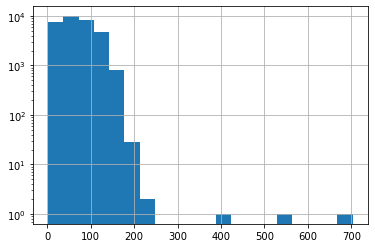

In [5]:
length_dist = train_df["text"].apply(len)
length_dist.hist(log=True, bins=20)

<AxesSubplot:>

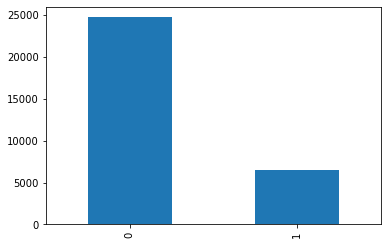

In [6]:
train_df["label"].value_counts().plot(kind="bar")

In [7]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [8]:
tokenized_train = tokenizer(train_df["text"].to_list(), max_length=512, truncation=True)
tokenized_val = tokenizer(val_df["text"].to_list(), max_length=512, truncation=True)
tokenized_test = tokenizer(test_df["text"].to_list(), max_length=512, truncation=True)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_text, labels):
        self.tokenized_text = tokenized_text
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.tokenized_text.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TextDataset(tokenized_train, train_df["label"].to_list())
val_dataset = TextDataset(tokenized_val, val_df["label"].to_list())
test_dataset = TextDataset(tokenized_test, test_df["label"].to_list())

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
train_dataset[0]

{'input_ids': tensor([     0,  51776,    110,   1733,     47,  43658,     64, 134665,     10,
          24234,  54452,      2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor(0)}

In [11]:
import numpy as np

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=-1).astype(bool)
    labels = labels.astype(bool)
    
    tp = (preds & labels).astype(np.float32).sum()
    fp = (preds & ~labels).astype(np.float32).sum()
    tn = (~preds & ~labels).astype(np.float32).sum()
    fn = (~preds & labels).astype(np.float32).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + tn + fp + fn)
    return {"f1": f1, "acc": acc}

In [12]:
training_args = TrainingArguments(
    output_dir="results",
    logging_dir="logs",
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=2445, training_loss=0.24974309081680204, metrics={'train_runtime': 270.5769, 'train_samples_per_second': 9.036, 'total_flos': 0, 'epoch': 5.0})

In [13]:
model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-1467")
model = model.cuda()
model = model.eval()

In [14]:
test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=data_collator)

In [15]:
results = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.cuda() for k,v in batch.items()}
        output = model(**batch)
        results.append(output["logits"].cpu())

In [16]:
results = torch.cat(results)
results = torch.argmax(results, dim=1)
results

tensor([1, 0, 0,  ..., 0, 0, 0])

In [17]:
submission = test_df.copy()
submission["label"] = results.numpy()
submission

,text,label
0,I was already over the edge with Cassie Zamora...,1
1,I think you're right. She has oodles of cash a...,0
2,Haha I love this. I used to give mine phone bo...,0
3,Probably out of desperation as they going no a...,0
4,Sorry !! You’re real good at that!!,0
...,...,...
8677,Yeah no...I would find it very demeaning,1
8678,This is how mafia works,0
8679,Ah thanks 👍🏻,0
8680,I ask them straight why they don't respect my ...,0


In [18]:
submission.to_csv("submission.csv", index=False)